<a href="https://colab.research.google.com/github/JangAyeon/ToBigs/blob/master/%5B5%5DPCA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 차원축소 Assignment2

## MNIST data에 적용을 해보기

mnist-original.mat 파일과 같은 위치에서 주피터 노트북을 열어주세요

In [1]:
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml
from scipy import io
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

In [2]:
mnist = io.loadmat('mnist-original.mat') #mnist 손글씨 데이터를 불러옵니다
X = mnist['data'].T
y = mnist['label'].T

# 데이터 정보!
- 7만개의 작은 숫자 이미지
- 행 열이 반대로 되어있음 -> 전치
- grayscale 28x28 pixel = 784 feature
- 각 picel은 0~255의 값
- label = 1~10 label이 총 10개인거에 주목하자

In [3]:
print(X.shape, y.shape)

(70000, 784) (70000, 1)


In [4]:
# data를 각 픽셀에 이름붙여 표현
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# df에 라벨 y를 붙여서 데이터프레임 생성
df['y'] = y
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (70000, 785)


In [6]:
df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.0
69996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.0
69997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.0
69998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.0


<Figure size 432x288 with 0 Axes>

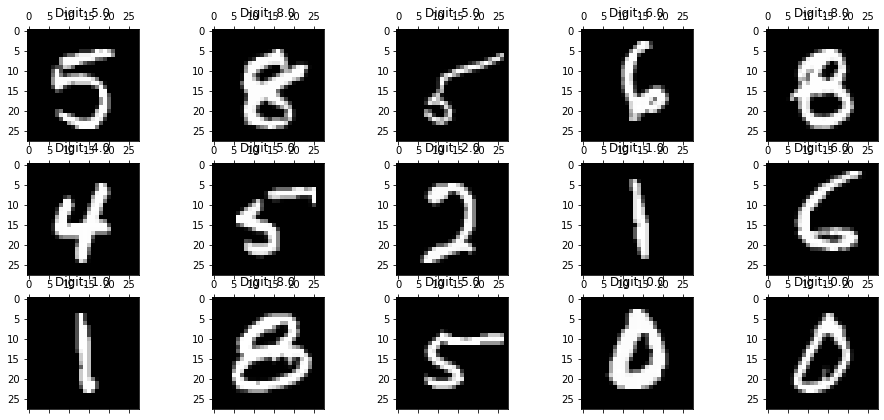

In [7]:
# 데이터 형태 시각화

import matplotlib.pyplot as plt

rndperm = np.random.permutation(df.shape[0])

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'y'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

### [1] train_test_split 
: data-> train(0.8), test(0.2)로 분할 

In [8]:
from sklearn.model_selection import train_test_split #random_state=42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### [2] Feature Scaling : STD

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train) #train -> fit 이랑 transform 적용
X_test_std = scaler.transform(X_test) #train -> transform 적용


#원본데이터 & PCA 축소 데이터 & LDA 축소 데이터 비교

####**[3] 주성분 갯수 구하기**


*   Elbow Point : 곡선의 기울기 급격 감소
*   Kaiser's Rule : 고유값 1 이상의 주성분들
*   누적설명률 : 70% ~ 80% 이상 지점




#####**[3-1] PCA**

In [10]:
from sklearn.decomposition import PCA

pca = PCA() #default : (n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
pca.fit(X_train_std)

eigenvalue_sort=np.sort(pca.explained_variance_)[::-1] #eigenvalue를 큰 거부터 차례로 나열
eigenvalue_sort_ratio=np.sort(pca.explained_variance_ratio_)[::-1] #eigenvalue 비율을 큰 거부터 차례로 나열

######**1. Elbow Point**
: 내립차순으로 나열한 상위 13개의 eigenvalue까지만 유의미

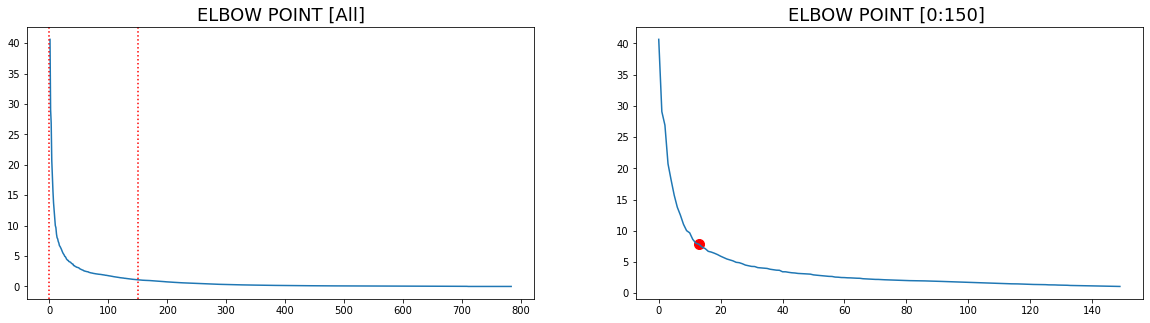

In [11]:
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.plot(range(1, X.shape[1]+1), eigenvalue_sort) 
plt.title('ELBOW POINT [All]', size=18) #구간이 넓어서 ELBOW Point를 찾기 힘듬
plt.axvline(0, color='red', ls=':') #0~150 사이에 Elbow Point가 있을 것으로 추정
plt.axvline(150, color='red', ls=':')

plt.subplot(1,2,2)
plt.plot(range(150), eigenvalue_sort[:150]) #0~150까지로 구간 특정
plt.title('ELBOW POINT [0:150] ', size=18)
plt.scatter(x=13,y=eigenvalue_sort[13], s=100, c='red') #대략 13에서 Elbow Point보임
plt.show() 

######**2. Kaiser's Rule**
:사용된 주성분이 대략 160개까지만 고유값이 1이상

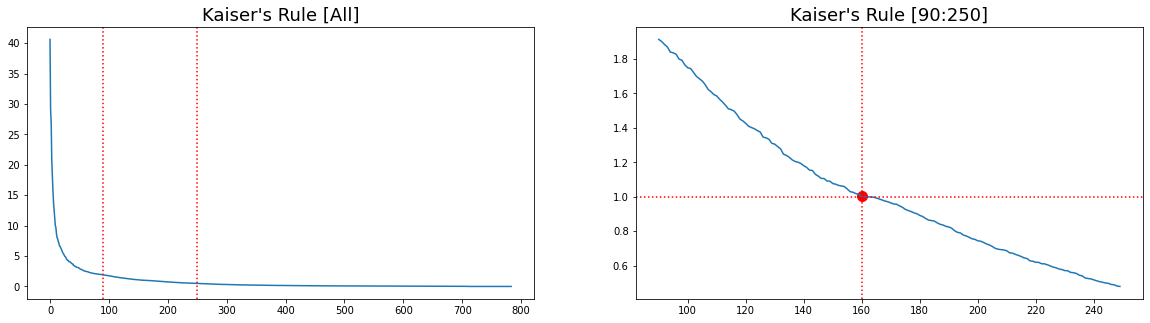

In [12]:
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.plot(range(eigenvalue_sort.shape[0]), eigenvalue_sort) #갯수에 따른 고유값을 plot
plt.title("Kaiser's Rule [All]", size=18) # 구간이 넓어서 어디까지 고유값이 1이상인지 찾기 어려움
plt.axvline(90, color='red', ls=':') #90~250사이에 고유값이 1이상인 주성분 갯수의 마지노선이 있을 것이라고 추정
plt.axvline(250, color='red', ls=':')

plt.subplot(1,2,2)
plt.plot(range(90,250), eigenvalue_sort[90:250]) #90~250으로 범위를 특정해 살펴봄
plt.title("Kaiser's Rule [90:250]", size=18) 
plt.axhline(1, color='red', ls=':') #고유값이 1임을 나타내는 y축 그리기
plt.axvline(160, color='red', ls=':') #160개의 주성분을 나타내는 x축 그리기
plt.scatter(x=160, y=eigenvalue_sort[160], s=100, c='red') #고유값 : 1, 사용된 주성분 갯수 : 160
plt.show()

######**3. 누적 설명률 : 70% ~ 80%**

: 대략 147개의 주성분을 사용한 경우 대략 80%의 누적설명률을 가짐

In [13]:
variance_ratio_list=[]
variance_ratio=0
for i in eigenvalue_sort_ratio:
  variance_ratio+=i
  variance_ratio_list.append(variance_ratio)
  if variance_ratio_list.index(variance_ratio_list[-1])%10 == 0: #주성분 10개 단위로 끊어서 누적 설명률 출력
    print(variance_ratio_list.index(variance_ratio_list[-1])," : ",variance_ratio) 
    #대략 90개 ~ 240개의 주성분을 선택하면 누적설명률이 70% ~ 90%에 해당

0  :  0.05675740166070152
10  :  0.29071145611814536
20  :  0.38963759824125044
30  :  0.45876748026756314
40  :  0.5130594339503893
50  :  0.5575312565205024
60  :  0.5950293188363694
70  :  0.6278671658574363
80  :  0.6574632548171695
90  :  0.6850682588924495
100  :  0.7105801604398913
110  :  0.7337490456588135
120  :  0.7546413175086171
130  :  0.7736440149271084
140  :  0.7907990111792113
150  :  0.8064438551371623
160  :  0.820966245564844
170  :  0.8347525549338625
180  :  0.8476934268161163
190  :  0.8596008360806754
200  :  0.870459830278575
210  :  0.8803817928227854
220  :  0.8894417813077392
230  :  0.8977597661390322
240  :  0.9053408363391245
250  :  0.9122401970900879
260  :  0.9185862070410493
270  :  0.9243833451748649
280  :  0.9297374616837945
290  :  0.9346837735510969
300  :  0.9392297441887358
310  :  0.9434275765691041
320  :  0.9473320457416524
330  :  0.9509620305927255
340  :  0.9543251377769888
350  :  0.9574509481035217
360  :  0.9603378007974764
370  :  0.

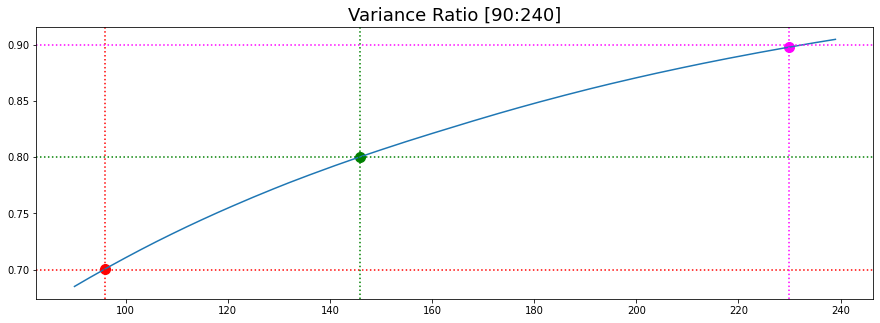

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(range(90,240), variance_ratio_list[90:240]) #90~250으로 범위를 특정해 살펴봄
plt.title("Variance Ratio [90:240]", size=18) 

plt.scatter(x=96, y=variance_ratio_list[96], s=100, c='red') #97개 주성분 : 대략 70% 누적설명률 
plt.axhline(0.7, color='red', ls=':') 
plt.axvline(96, color='red', ls=':') 


plt.scatter(x=146, y=variance_ratio_list[146], s=100, c='green') #147개 주성분 : 대략 80% 누적설명률 
plt.axhline(0.8, color='green', ls=':') 
plt.axvline(146, color='green', ls=':') 

plt.scatter(x=230, y=variance_ratio_list[230], s=100, c='magenta') #231개 주성분 : 대략 90% 누적설명률 
plt.axhline(0.9, color='magenta', ls=':') 
plt.axvline(230, color='magenta', ls=':') 

plt.show()

#####**[3-2] LDA**


In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis() #default : (solver='svd', shrinkage=None, priors=None, n_components=None, store_covariance=False, tol=0.0001, covariance_estimator=None)
lda.fit(X_train_std,y_train)

eigenvalue_sort_ratio=np.sort(lda.explained_variance_ratio_)[::-1] #eigenvalue 비율을 큰 거부터 차례로 나열

######**1.누적 설명률 : 70% ~ 80%**
: 대략 5개의 주성분을 사용한 경우 대략 80%의 누적설명률을 가짐

In [16]:
variance_ratio_list=[]
variance_ratio=0
for i in eigenvalue_sort_ratio:
  variance_ratio+=i
  variance_ratio_list.append(variance_ratio)
  print(variance_ratio_list.index(variance_ratio_list[-1])," : ",variance_ratio) 

0  :  0.2370811723991113
1  :  0.4403694039372203
2  :  0.6183522288383785
3  :  0.7246871142870687
4  :  0.8188435036237985
5  :  0.8878111362398824
6  :  0.9377164859315918
7  :  0.9727940925805025
8  :  1.0


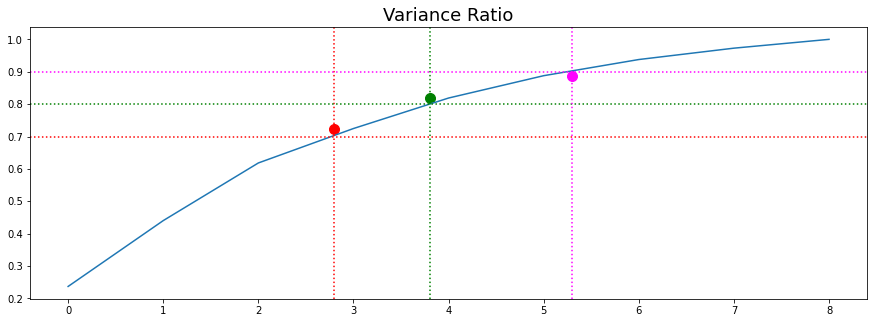

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(range(eigenvalue_sort_ratio.shape[0]), variance_ratio_list) 
plt.title("Variance Ratio", size=18) 

plt.axhline(0.7, color='red', ls=':') 
plt.axvline(2.8, color='red', ls=':') 
plt.scatter(x=2.8, y=variance_ratio_list[3], s=100, c='red') #4개 주성분 : 대략 70% 누적설명률 

plt.axhline(0.8, color='green', ls=':') 
plt.axvline(3.8, color='green', ls=':') 
plt.scatter(x=3.8, y=variance_ratio_list[4], s=100, c='green') #5개 주성분 : 대략 80% 누적설명률 

plt.axhline(0.9, color='magenta', ls=':') 
plt.axvline(5.3, color='magenta', ls=':') 
plt.scatter(x=5.3, y=variance_ratio_list[5], s=100, c='magenta') #6개 주성분 : 대략 90% 누적설명률 
plt.show()

#### **[4] Data 생성**

1.  Original Data => Dimension 784
2.  PCA Data => Dimension 160
3.  LDA Data => Dimension 5



In [18]:
#Split train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
#1. Original Data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train) 
X_test_std = scaler.transform(X_test) 
print("Original Data Dimension : ", X_test_std.shape[1])

Original Data Dimension :  784


In [20]:
#2. PCA Data
pca_best=PCA(n_components=160)
X_train_pca = pca_best.fit_transform(X_train_std) 
X_test_pca = pca_best.transform(X_test_std) 
print("PCA Data Dimension : ", X_test_pca.shape[1])

PCA Data Dimension :  160


In [21]:
#3. LDA Data
lda_best = LinearDiscriminantAnalysis(n_components=5)
X_train_lda = lda_best.fit_transform(X_train_std, y_train)
X_test_lda = lda_best.transform(X_test_std)
print("LDA Data Dimension : ", X_test_lda.shape[1])

LDA Data Dimension :  5


##**[5]머신러닝 기법을 이용하여 학습**

 이때 time stamp를 찍어서 training 시간을 비교하고, test accuracy도 비교해주세요<br>
(원본 데이터 & PCA 축소 데이터 & LDA 축소 데이터 비교)

In [22]:
import time
from sklearn.metrics import *

#### **[5-1] Logistic Regression**

In [23]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

#####**Original Data**



In [24]:
start=time.time()
lr.fit(X_train_std,y_train)
end=time.time()
print("Time : ",end-start)
pred=lr.predict(X_test_std)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  37.22301506996155
Accuracy :  0.9166428571428571


#####**PCA Data**

In [25]:
start=time.time()
lr.fit(X_train_pca,y_train)
end=time.time()
print("Time : ",end-start)
pred=lr.predict(X_test_pca)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  11.441078901290894
Accuracy :  0.9207142857142857


#####**LDA Data**

In [27]:
start=time.time()
lr.fit(X_train_lda,y_train)
end=time.time()
print("Time : ",end-start)
pred=lr.predict(X_test_lda)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  4.543967008590698
Accuracy :  0.8343571428571429


#### **[5-2] Logistic Random Forest**

In [28]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

#####**Original Data**

In [30]:
start=time.time()
rfc.fit(X_train_std, y_train)
end=time.time()
print("Time : ",end-start)
pred = rfc.predict(X_test_std)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  43.32106876373291
Accuracy :  0.9685714285714285


#####**PCA Data**

In [31]:
start=time.time()
rfc.fit(X_train_pca, y_train)
end=time.time()
print("Time : ",end-start)
pred = rfc.predict(X_test_pca)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  103.34458875656128
Accuracy :  0.9435714285714286


#####**LDA Data**

In [32]:
start=time.time()
rfc.fit(X_train_lda, y_train)
end=time.time()
print("Time : ",end-start)
pred = rfc.predict(X_test_lda)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  18.44027018547058
Accuracy :  0.8475714285714285


#### **[5-3] KNN**

In [33]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

#####**Original Data**

In [34]:
start=time.time()
knn.fit(X_train_std, y_train)
end=time.time()
print("Time : ",end-start)
pred = knn.predict(X_test_std)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  24.739301919937134
Accuracy :  0.9461428571428572


#####**PCA Data**

In [35]:
start=time.time()
knn.fit(X_train_pca, y_train)
end=time.time()
print("Time : ",end-start)
pred = knn.predict(X_test_pca)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  1.7684922218322754
Accuracy :  0.9565714285714285


#####**LDA Data**

In [36]:
start=time.time()
knn.fit(X_train_lda, y_train)
end=time.time()
print("Time : ",end-start)
pred = knn.predict(X_test_lda)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  0.06582117080688477
Accuracy :  0.8377857142857142


#### **[5-4] SVM**

In [37]:
from sklearn.svm import SVC
svc=SVC()

#####**Original Data**

In [38]:
start=time.time()
svc.fit(X_train_std, y_train)
end=time.time()
print("Time : ",end-start)
pred = svc.predict(X_test_std)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  846.1114161014557
Accuracy :  0.9652142857142857



#####**PCA Data**



In [39]:
start=time.time()
svc.fit(X_train_pca, y_train)
end=time.time()
print("Time : ",end-start)
pred = svc.predict(X_test_pca)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  186.97669649124146
Accuracy :  0.9694285714285714


#####**LDA Data**

In [40]:
start=time.time()
svc.fit(X_train_lda, y_train)
end=time.time()
print("Time : ",end-start)
pred = svc.predict(X_test_lda)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  23.39992070198059
Accuracy :  0.852


#### **[5-5] LightGBM**

In [41]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()

#####**Original Data**

In [42]:
start=time.time()
lgbm.fit(X_train_std, y_train)
end=time.time()
print("Time : ",end-start)
pred = lgbm.predict(X_test_std)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  294.77987027168274
Accuracy :  0.9729285714285715


#####**PCA Data**

In [43]:
start=time.time()
lgbm.fit(X_train_pca, y_train)
end=time.time()
print("Time : ",end-start)
pred = lgbm.predict(X_test_pca)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  86.44989085197449
Accuracy :  0.9517857142857142


#####**LDA Data**

In [44]:
start=time.time()
lgbm.fit(X_train_lda, y_train)
end=time.time()
print("Time : ",end-start)
pred = lgbm.predict(X_test_lda)
print("Accuracy : ",accuracy_score(y_test,pred))

Time :  4.752392053604126
Accuracy :  0.8480714285714286


#**[6]결과 비교**

##**1. Logisitic Regression**

|Data|Time|Accuracy|
|:---:|:---:|:---:|
|Original Data|37.2230|0.9166|
|PCA Data|11.4411|0.9207|
|LDA Data|4.54340|0.8344|

##**2. Logisitic Random Forest**

|Data|Time|Accuracy|
|:---:|:---:|:---:|
|Original Data|43.3211|0.9686|
|PCA Data|103.3446|0.9436|
|LDA Data|18.44027|0.8476|

##**3. KNN**

|Data|Time|Accuracy|
|:---:|:---:|:---:|
|Original Data|24.7393|0.9461|
|PCA Data|1.7685|0.9566|
|LDA Data|0.0658|0.8378|

##**4. SVM**

|Data|Time|Accuracy|
|:---:|:---:|:---:|
|Original Data|846.1114|0.9652|
|PCA Data|186.9767|0.9694|
|LDA Data|23.4|0.852|

##**5. LightGBM**

|Data|Time|Accuracy|
|:---:|:---:|:---:|
|Original Data|294.78|0.9729|
|PCA Data|86.4499|0.9518|
|LDA Data|4.7524|0.8481|

#**[7]Best Accuracy**

|Data|Model|Accuracy|
|:---:|:---:|:---:|
|Original Data|LightGBM|0.9729|
|PCA Data|SVM|0.9694|
|LDA Data|SVM|0.852|

**PCA Data** <br>
* Dimension : 160
* Model : SVM
* Accuracy : 0.9694
